# Create line-by-line look-up tables for UV cross sections

The built-in programmes in NEMESIS with names *Calc_lbltable* and *Calc_fnktablec* can be used to create line-by-line or correlated-k look-up tables based on the spectroscopic parameters tabulated in databases such as HITRAN or GEISA. While this is typically used for most cases, these spectroscopic parameters are often not tabulated for ultraviolet wavelengths. Instead, it is more common to find tabulated cross sections at a given temperature and pressure in databases such as [HITRAN](https://hitran.org/xsc/) or the [MPI-Mainz UV/VIS Spectral Atlas](https://uv-vis-spectral-atlas-mainz.org/uvvis/index.html).

In this notebook, we are going to show how the cross sections in these databases can be converted into a format readable by NEMESIS (i.e., line-by-line .lta tables). In particular, we are going to download the cross sections of OClO from [HITRAN](https://hitran.org/xsc/) as an example, and write the NEMESIS look-up table.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt

## 1. Reading the UV cross sections from HITRAN

After we have downloaded the UV cross sections from HITRAN, we can just read the files using the function below.

### Defining function to read HITRAN files

In [2]:
def read_hitran_xs_file(filename):

    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()


    #Reading the header
    header = lines[0]
    vmin = float(header.split()[1])
    vmax = float(header.split()[2])
    nv = int(header.split()[3])
    temp = float(header.split()[4])
    
    # Skip the header line
    data_lines = lines[1:]
    
    # Initialize an empty list to store the values
    values = []
    
    # Iterate through each line in the remaining lines
    for line in data_lines:
        # Split the line by spaces and convert each element to float
        line_values = [float(value) for value in line.split()]
        # Extend the values list with the values from the current line
        values.extend(line_values)


    if len(values)!=nv:
        sys.exit('error :: Number of values in cross section array does not coincide with NWAVE')

    waven = np.linspace(vmin,vmax,nv)
    
    return waven,np.array(values),temp

### Reading the HITRAN files

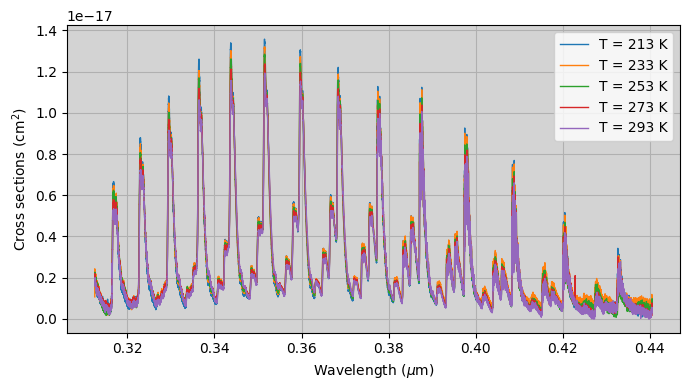

In [3]:
files = ['cross_sections/OClO_213.0_0.0_22700.1-32000.2_09.xsc',
         'cross_sections/OClO_233.0_0.0_22700.1-32000.2_09.xsc',
         'cross_sections/OClO_253.0_0.0_22700.1-32000.2_09.xsc',
         'cross_sections/OClO_273.0_0.0_22700.1-32000.2_09.xsc',
         'cross_sections/OClO_293.0_0.0_22700.1-32000.2_09.xsc']

mwave = 100000
ntemp = len(files)   #Each file corresponds to a different temperature

nwave = np.zeros(ntemp,dtype='int32')
wavel = np.zeros((mwave,ntemp))
xs = np.zeros((mwave,ntemp))
templevels = np.zeros(ntemp)

ix = 0
for file in files:

    wavenx, xsx, tempx = read_hitran_xs_file(file)  #The files tabulate the cross sections in wavenumber, and we want them in wavelength

    #Calculating wavelengths
    wavelx = 1./wavenx * 1.0e4

    #Sorting the arrays in wavelength space
    iord = np.argsort(wavelx)
    wavelx = wavelx[iord]
    xsx = xsx[iord]

    #Filling the arrays
    nwave[ix] = len(wavelx)
    wavel[0:len(wavelx),ix] = wavelx[:]
    xs[0:len(wavelx),ix] = xsx[:]
    templevels[ix] = tempx
    
    ix += 1

if len(np.unique(nwave))!=1:
    sys.exit('error :: All files must be tabulated at the same wavelengths')

wavel = wavel[0:nwave[0],0]
xs = xs[0:nwave[0],:]

#Making summary plot
fig,ax1 = plt.subplots(1,1,figsize=(7,4))

for i in range(ntemp):
    ax1.plot(wavel,xs[:,i],label='T = '+str(int(templevels[i]))+' K',linewidth=1.)
ax1.grid()
ax1.legend()
ax1.set_facecolor('lightgray')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Cross sections (cm$^2$)')
plt.tight_layout()

## 2. Creating the line-by-line look-up tables

Once we have our cross sections, we just need to perform a few changes to make them compatible with the NEMESIS look-up tables. In particular, NEMESIS requires the cross sections in the look-up tables to be tabulated in an even grid of wavelengths or wavenumbers. Therefore, we need to interpolate our cross sections into an even grid of wavelengths.

Similarly, the NEMESIS look-up tables allow for a dependency of the cross sections on pressure. In our case, the cross sections are tabulated only as a function of temperature, but we still need to include that potential pressure dependence in the format of our arrays.

### Re-formatting the arrays

In [4]:
#Interpolating to an even grid of wavelengths
#############################################################

nwave = len(wavel)
delv = np.zeros(nwave-1)
for i in range(nwave-1):
    delv[i] = wavel[i+1] - wavel[i]

delvx = delv.min()
vminx = wavel.min()
vmaxx = wavel.max()

wavelx = np.arange(vminx,vmaxx+delvx,delvx)
xsx = np.zeros((len(wavelx),ntemp))
for i in range(ntemp):
    xsx[:,i] = np.interp(wavelx,wavel,xs[:,i])

#Including the dimension for pressure in the arrays
##############################################################

npress = 2 ; presslevels = np.array([1.0e-3, 1.0e-5])   #Just some arbitrary pressures

k = np.zeros((len(wavelx),npress,ntemp))
for i in range(npress):
    k[:,i,:] = xsx[:,:]

### Writing the look-up table

In [5]:
outfile = 'OClO_HITRAN'  #Name of the look-up table
gasID = 132              #Radtran ID of OClO
isoID = 0                #Isotope ID

ans.write_lbltable(outfile,npress,ntemp,gasID,isoID,presslevels,templevels,len(wavelx),vminx,delvx,k)

## 3. Reading the NEMESIS look-up table

Now we can read the NEMESIS look-up table using the built-in functions in archNEMESIS. 

Note that the cross sections in NEMESIS are carried with a factor of 10$^{20}$ that we need to correct for when plotting them.

In [10]:
#Writing .lls file listing the look-up tables to read
f = open('lookup.lls','w')
f.write(outfile+'.lta')
f.close()

#Loading Spectroscopy class
Spectroscopy = ans.Spectroscopy_0()
Spectroscopy.read_lls('lookup')

#Printing some useful information
Spectroscopy.summary_info()

#Reading the look-up table
Spectroscopy.read_tables()

Calculation type ILBL ::  2  (line-by-line)
Number of radiatively-active gaseous species ::  1
Gaseous species ::  ['ClO2']
Number of spectral points ::  36258
Wavelength range ::  0.31249821186065674 - 0.4405264996328242
Step size ::  3.5311329611431574e-06
Number of temperature levels ::  5
Temperature range ::  213.0 - 293.0 K
Number of pressure levels ::  2
Pressure range ::  1e-05 - 0.001 atm


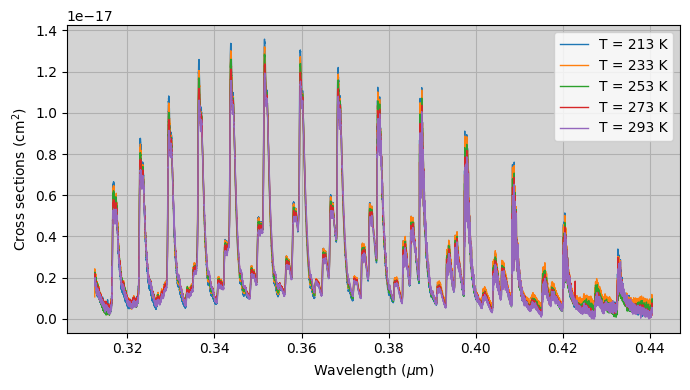

In [11]:
#Making summary plot
fig,ax1 = plt.subplots(1,1,figsize=(7,4))

for i in range(Spectroscopy.NT):
    ax1.plot(Spectroscopy.WAVE,Spectroscopy.K[:,0,i]*1.0e-20,label='T = '+str(int(Spectroscopy.TEMP[i]))+' K',linewidth=1.)
ax1.grid()
ax1.legend()
ax1.set_facecolor('lightgray')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Cross sections (cm$^2$)')
plt.tight_layout()